In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
# Constants
NUM_FEATURES = 21
NUM_HIDDEN_NEURONS = [5, 10, 15, 20, 25]
NUM_CLASSES = 3

learning_rate = 0.01
weight_decay = 1e-6
epochs = 5000
batch_size = 32
num_folds = 5
seed = 10
np.random.seed(seed)

In [4]:
# Read from CSV
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 # one hot matrix

In [5]:
# Shuffle
print('Sample size: %d'%(trainX.shape[0]))
s = np.arange(trainX.shape[0]) # Create an index array
np.random.shuffle(s) # Shuffle the index array
trainX, trainY = trainX[s], trainY[s]

Sample size: 2126


In [6]:
# Split into 70:30 (train:test)
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.30, random_state=seed, shuffle=True)
print(trainX.shape)

(1488, 21)


In [7]:
# Create the model
def createModel(num_neurons):
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    # Build the graph for the deep net
    w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w1')
    b1 = tf.Variable(tf.zeros([num_neurons]), name='b1')
    hidden_relu = tf.nn.relu(tf.matmul(x, w1) + b1, name='relu')

    w2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons))), name='w2')
    b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
    logits  = tf.matmul(hidden_relu, w2) + b2

    # Apply Softmax activation function to output
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)

    # Loss function with L2 Regularization with b = 10^-6
    loss1 = tf.reduce_mean(cross_entropy)
    regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
    loss = tf.reduce_mean(loss1 + weight_decay * regularizers)

    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    return x, y_, train_op, accuracy

In [8]:
# Main
all_cv_acc = []

# Split dataset into number of folds
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# For each number of hidden-layer neurons (5,10,15,20,25)
for n in NUM_HIDDEN_NEURONS:
    print('================= Num of Neurons: %d =================' %n)
    neuron_acc = []
    
    # Create the model
    x, y_, train_op, accuracy = createModel(n)

    # For each fold (CV)
    for train_index, test_index in kf.split(trainX):
        fTrainX, fTestX = trainX[train_index], trainX[test_index]
        fTrainY, fTestY = trainY[train_index], trainY[test_index]

        # Run experiment
        with tf.Session() as sess:
            print('Experiment %d of %d: ' %(len(neuron_acc)+1, num_folds))
            sess.run(tf.global_variables_initializer())

            exp_train_acc = []
            exp_test_acc = []

            # For each epoch
            for e in tqdm(range(epochs)):
                epoch_train_acc = []

                # Run mini-batch
                for start, end in zip(range(0, len(fTrainX), batch_size), range(batch_size, len(fTrainX), batch_size)):
                    train_op.run(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]})
                    epoch_train_acc.append(accuracy.eval(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]}))

                exp_train_acc.append(np.mean(np.array(epoch_train_acc)))
                exp_test_acc.append(accuracy.eval(feed_dict={x: fTestX, y_: fTestY}))

#                 if e % 100 == 0:
#                     print('Iter: %d' %e, ' | ', 'Train acc: %g' %exp_train_acc[e], ' | ', 'Test acc: %g' %exp_test_acc[e])

        neuron_acc.append(exp_test_acc)
        
    # After all experiments are completed, compute mean
    all_cv_acc.append(np.mean(np.array(neuron_acc), axis=0))
    print()

================= Num of Neurons: 5 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.92it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.49it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.22it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.10it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.19it/s]



================= Num of Neurons: 10 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.98it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.94it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.96it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.48it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.71it/s]



================= Num of Neurons: 15 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.80it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.39it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.37it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.21it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.80it/s]



================= Num of Neurons: 20 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.71it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.29it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.85it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.52it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.59it/s]



================= Num of Neurons: 25 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.19it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.94it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.57it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.12it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.02it/s]


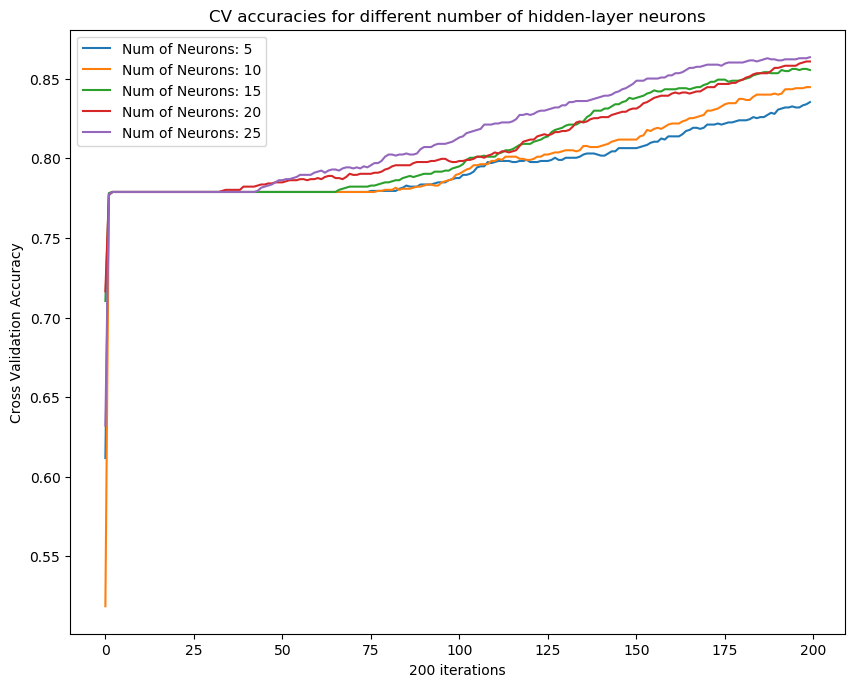

In [13]:
# Plot curves
plt.figure(1, figsize=(10, 8), dpi= 100)
plt.title('CV accuracies for different number of hidden-layer neurons')

for n, i in zip(NUM_HIDDEN_NEURONS, range(len(NUM_HIDDEN_NEURONS))):
    plt.plot(range(epochs), all_cv_acc[i], label='Num of Neurons: %d' %n)

plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Cross Validation Accuracy')
plt.legend()
# plt.savefig('PartA_Qn3a_BatchSizes.png')
plt.show()